# Collecting Data

### The Boltzmann Wealth Model

If you want to get straight to the tutorial checkout these environment providers:<br>
(with Google Account) [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/projectmesa/mesa/blob/main/docs/tutorials/2_collecting_data.ipynb)<br>
(No Google Account) [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/projectmesa/mesa/main?labpath=docs%2Ftutorials%2F2_collecting_data.ipynb) (This can take 30 seconds to 5 minutes to load)

*If you are running locally, please ensure you have the latest Mesa version installed.*

## Tutorial Description

This tutorial extends the Boltzmann wealth model from the [Adding Space tutorial](https://mesa.readthedocs.io/latest/tutorials/1_adding_space.html), by adding Mesa's data collection module.

In this portion, we will collect both model level data and agent level data to better understand the dynamics of our model.

*If you are starting here please see the [Running Your First Model tutorial](https://mesa.readthedocs.io/latest/tutorials/0_first_model.html) for dependency and start-up instructions*

### IN COLAB? - Run the next cell

### Import Dependencies
This includes importing of dependencies needed for the tutorial.

In [1]:
# Has multi-dimensional arrays and matrices.
# Has a large collection of mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

# Data visualization tools.
import seaborn as sns

import mesa

# Import Cell Agent and OrthogonalMooreGrid
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid

## Base Model

The below provides the base model from which we will add our space functionality.

This is from the [Adding Space tutorial](https://mesa.readthedocs.io/latest/tutorials/1_adding_space.html) tutorial. If you have any questions about it functionality please review that tutorial.

In [2]:
class MoneyAgent(CellAgent):
    """An agent with fixed initial wealth."""

    def __init__(self, model, cell):
        super().__init__(model)
        self.cell = cell  # Instantiate agent with location (x,y)
        self.wealth = 1

    # Move Function
    def move(self):
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        cellmates = [
            a for a in self.cell.agents if a is not self
        ]  # Get all agents in cell

        if self.wealth > 0 and cellmates:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        # Instantiate an instance of Moore neighborhood space
        self.grid = OrthogonalMooreGrid(
            (width, height), torus=True, capacity=10, random=self.random
        )

        # Create agents
        agents = MoneyAgent.create_agents(
            self,
            self.num_agents,
            # Randomly select agents cell
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

    def step(self):
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

Let's create a model with 100 agents on a 10x10 grid, and run it for 20 steps to make sure our base model works.

In [3]:
model = MoneyModel(100, 10, 10)
for _ in range(20):
    model.step()
# Let's make sure it worked
print(len(model.agents))

100


## Collecting Data

**Background:** So far, at the end of every model run, we've had to go and write our own code to get the data out of the model. This has two problems: it isn't very efficient, and it only gives us end results. If we wanted to know the wealth of each agent at each step, we'd have to add that to the loop of executing steps, and figure out some way to store the data.

Since one of the main goals of agent-based modeling is generating data for analysis, Mesa provides a class which can handle data collection and storage for us and make it easier to analyze.

The data collector stores three categories of data:
 - Model-level variables : Model-level collection functions take a model object as an input. Such as a function that computes a dynamic of the whole model (in this case we will compute a measure of wealth inequality based on all agent's wealth)
 - Agent-level variables: Agent-level collection functions take an agent object as an input and is typically the state of an agent attributes, in this case wealth.
 - Tables (which are a catch-all for everything else).

**Model-specific information:** We will collect two variables to show Mesa capabilities.
- At the model level, let's measure the model's [Gini Coefficient](https://en.wikipedia.org/wiki/Gini_coefficient), a measure of wealth inequality.
- At the agent level, we want to collect every agent's wealth at every step.

**Code implementation:**

Let's add a DataCollector to the model with [`mesa.DataCollector`](https://github.com/projectmesa/mesa/blob/main/mesa/datacollection.py), and collect the agent's wealth and the gini coefficient at each time step. In the below code each new line of code is described with a comment. These additions are described below.

**Helper Function**<br>
\# Add function for model level collection
-*Description:* Helper function used by the model class to compute the gini coefficient as described previously.
-*API:* N/A

**MoneyModel Class**<br>
\# Instantiate DataCollector
- *Description:* Create a mesa data collector instance and use keyword arguments (kwargs) `model_reporters` and `agent_reporters` to pass in a dictionary, where the key is the name of the data collected and the value is either function (i.e. computer gini) or an attribute (i.e. "wealth"). If it is an attribute it is passed in as a string.
- *API:* [Data Collection](https://mesa.readthedocs.io/latest/apis/datacollection.html)

\# Collect data each step
- *Description:* Call the `collect` method from `DataCollector`. This causes the reporters to collect the data at each step. If this is not put in the step function then the data collector will collect the described information at the end of the model run. If you want to collect the data only on lets say the 5th step, then you can just add an  `if` statement to only collect on the fifth step.
- *API:* [DataCollector.collect](https://mesa.readthedocs.io/latest/apis/datacollection.html)

In [4]:
# Add function for model level collection
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B


class MoneyAgent(CellAgent):
    """An agent with fixed initial wealth."""

    def __init__(self, model, cell):
        super().__init__(model)
        self.cell = cell
        self.wealth = 1

    def move(self):
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        cellmates = [a for a in self.cell.agents if a is not self]

        if self.wealth > 0 and cellmates:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = OrthogonalMooreGrid(
            (width, height), torus=True, capacity=10, random=self.random
        )
        # Instantiate DataCollector
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        )

        # Create agents
        agents = MoneyAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

    def step(self):
        # Collect data each step
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

At every step of the model, the datacollector will collect and store the model-level current Gini coefficient, as well as each agent's wealth, associating each with the current step.

We run the model just as we did above. Now is when an interactive session, especially via a notebook, comes in handy: the DataCollector can export the data it has collected as a pandas* DataFrame, for easy and interactive analysis.

*If you are new to Python, please be aware that pandas is already installed as a dependency of Mesa and that [pandas](https://pandas.pydata.org/docs/) is a "fast, powerful, flexible and easy to use open source data analysis and manipulation tool". Pandas is a great resource to help analyze the data collected in your models.

In [5]:
model = MoneyModel(100, 10, 10)
for _ in range(100):
    model.step()

### Analyzing MoneyModel Data

**Code implementation:**

\# Extract MoneyModel data in a Pandas dataframe
- *Description:* Call `DataCollector.get_model_vars_dataframe()` method to get the model reporters (in this case gini coefficient) from the model object. We the use seaborn (sns) to do a line plot of the data of the model run.
- *API:* [get_model_vars_dataframe](https://mesa.readthedocs.io/latest/apis/datacollection.html#datacollection.DataCollector.get_model_vars_dataframe)

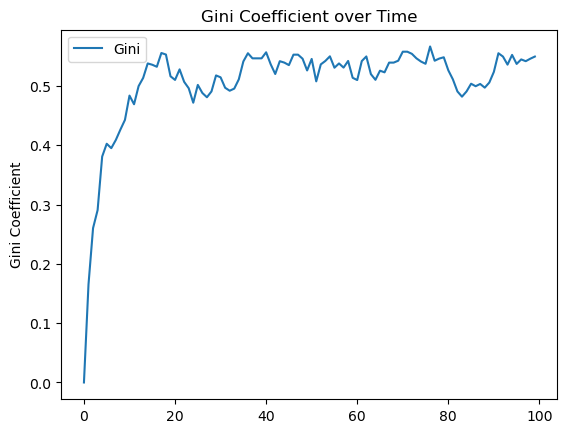

In [6]:
# Extract MoneyModel data in a Pandas dataframe
gini = model.datacollector.get_model_vars_dataframe()
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

### Analyzing an MoneyAgent Data

**Code implementation:**

\# Extract MoneyAgent data in a Pandas dataframe
- *Description:* Call `DataCollector.get_model_agent_dataframe()` method to get the agent reporters (in this case agent wealth attribute) from the model object.
- *API:* [get_model_agent_dataframe](https://mesa.readthedocs.io/latest/apis/datacollection.html#datacollection.DataCollector.get_agent_vars_dataframe)

In [7]:
# Extract MoneyAgent data in a Pandas dataframe
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head()

Wealth
Step AgentID        
1    1             1
     2             1
     3             1
     4             1
     5             1

You'll see that the DataFrame's index is pairings of model step and agent ID. This is because the data collector stores the data in a dictionary, with the step number as the key, and a dictionary of agent ID and variable value pairs as the value. The data collector then converts this dictionary into a DataFrame, which is why the index is a pair of (model step, agent ID). You can analyze it the way you would any other DataFrame. For example, to get a histogram of agent wealth at the model's end.

*Note: As the following code is pandas and seaborn we do not provide explanatory text*

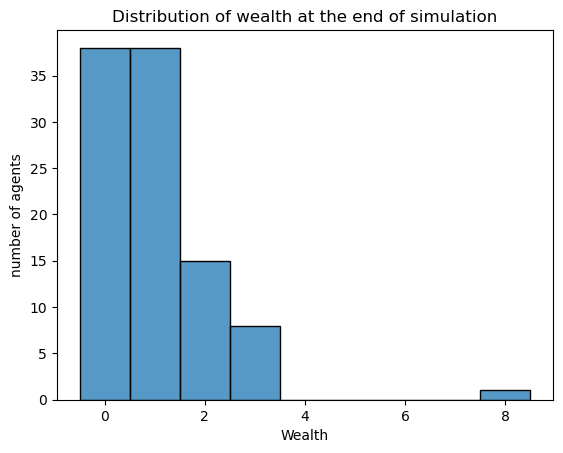

In [8]:
last_step = agent_wealth.index.get_level_values("Step").max()  # Get the last step
end_wealth = agent_wealth.xs(last_step, level="Step")[
    "Wealth"
]  # Get the welath of each agentat the last step
# Create a histogram of wealth at the last step
g = sns.histplot(end_wealth, discrete=True)
g.set(
    title="Distribution of wealth at the end of simulation",
    xlabel="Wealth",
    ylabel="number of agents",
);

Or to plot the wealth of a given agent (in this example, agent 7):

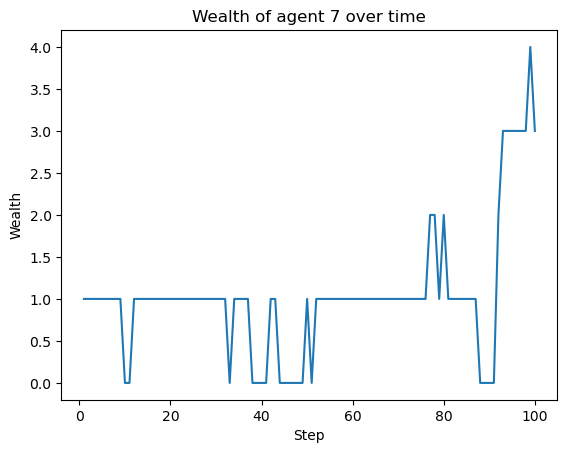

In [9]:
# Get the wealth of agent 7 over time
one_agent_wealth = agent_wealth.xs(7, level="AgentID")

# Plot the wealth of agent 7 over time
g = sns.lineplot(data=one_agent_wealth, x="Step", y="Wealth")
g.set(title="Wealth of agent 7 over time");

You can also plot a reporter of multiple agents over time.

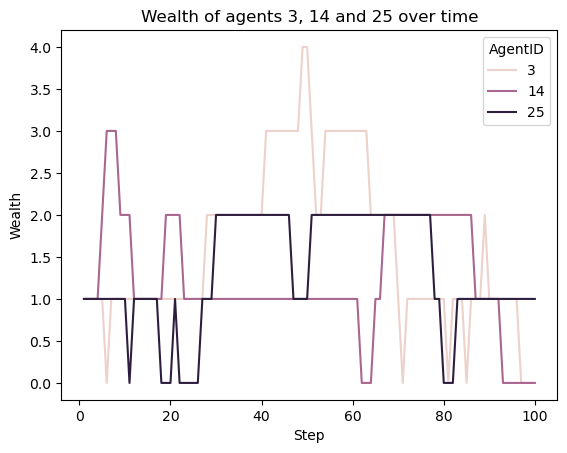

In [10]:
agent_list = [3, 14, 25]

# Get the wealth of multiple agents over time
multiple_agents_wealth = agent_wealth[
    agent_wealth.index.get_level_values("AgentID").isin(agent_list)
]
# Plot the wealth of multiple agents over time
g = sns.lineplot(data=multiple_agents_wealth, x="Step", y="Wealth", hue="AgentID")
g.set(title="Wealth of agents 3, 14 and 25 over time");

We can also plot the average of all agents, with a 95% confidence interval for that average.

[Text(0.5, 1.0, 'Average wealth over time')]

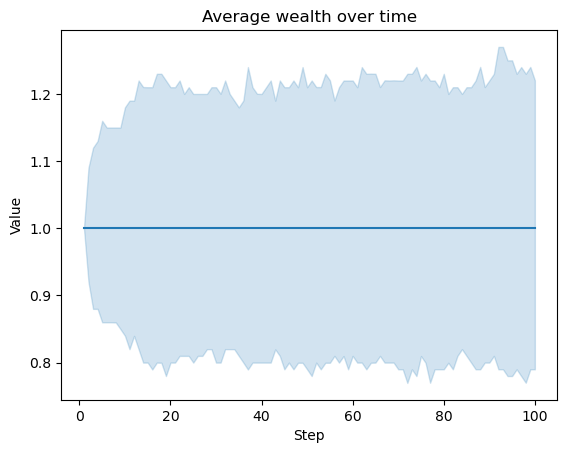

In [12]:
# Transform the data to a long format
agent_wealth_long = agent_wealth.T.unstack().reset_index()
agent_wealth_long.columns = ["Step", "AgentID", "Variable", "Value"]
agent_wealth_long.head(3)

# Plot the average wealth over time
g = sns.lineplot(data=agent_wealth_long, x="Step", y="Value", errorbar=("ci", 95))
g.set(title="Average wealth over time")

Which is exactly 1, as expected in this model, since each agent starts with one wealth unit, and each agent gives one wealth unit to another agent at each step.

You can also use pandas to export the data to a CSV (comma separated value) file, which can be opened by any common spreadsheet application or opened by pandas.

If you do not specify a file path, the file will be saved in the local directory. After you run the code below you will see two files appear (*model_data.csv* and *agent_data.csv*)

In [13]:
# save the model data (stored in the pandas gini object) to CSV
gini.to_csv("model_data.csv")

# save the agent data (stored in the pandas agent_wealth object) to CSV
agent_wealth.to_csv("agent_data.csv")

## Next Steps

Check out the [Agent Management Through AgentSet tutorial](https://mesa.readthedocs.io/latest/tutorials/3_agentset.html) on effective ways to manage agents.

[Comer2014] Comer, Kenneth W. “Who Goes First? An Examination of the Impact of Activation on Outcome Behavior in AgentBased Models.” George Mason University, 2014. http://mars.gmu.edu/bitstream/handle/1920/9070/Comer_gmu_0883E_10539.pdf

[Dragulescu2002] Drăgulescu, Adrian A., and Victor M. Yakovenko. “Statistical Mechanics of Money, Income, and Wealth: A Short Survey.” arXiv Preprint Cond-mat/0211175, 2002. http://arxiv.org/abs/cond-mat/0211175.